In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE

import argparse

from sequitur import quick_train
from sequitur.models import LSTM_AE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')
args.batch_size = 32
args.embedding_dim = 32
args.n_layers = 1
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.dropout = False
args.use_bn = False
args.lr = 0.001
args.epoch = 100

In [10]:
def get_colors_polygons(poly_division):
    file = gpd.read_file(f"data/shapefiles/{poly_division}.geojson").to_crs("EPSG:6933")
    centroids = file.centroid.apply(lambda x: (x.x, x.y)).to_list()
    centroids = np.array(centroids)
    for i in range(2):
        centroids[:, i] -= centroids[:, i].min()
        centroids[:, i] /= centroids[:, i].max()
        centroids[:, i] *= 511
    centroids = centroids.astype(int)

    img = Image.open("data/misc/bremm.png")
    # transform to array
    img = np.array(img)

    colors = []
    for i in centroids:
        colors.append(rgb2hex(img[i[1], i[0]] / 255))
    return colors

In [59]:
def plot_encodings(encodings, colors, ax = None):
    tsne = TSNE(n_components=2, random_state=0)
    encodings = tsne.fit_transform(encodings)
    if ax is None:
        plt.scatter(encodings[:, 0], encodings[:, 1], color=colors, alpha = 0.5)
        plt.show()
    else:
        ax.scatter(encodings[:, 0], encodings[:, 1], color=colors, alpha = 0.5)
        return ax

In [95]:
def plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts,
    rec,
):
    fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (20, 5))

    axs[0].plot(train_loss, label = "Train Loss")
    axs[0].set_title("Train Loss")

    plot_encodings(encodings, colors, ax = axs[1])
    axs[1].set_title("TSNE")

    samples = np.random.choice(len(ts), 3)
    len_dim = 0 if ts[0].shape[0] > ts[0].shape[1] else 1
    for i, sample_i in enumerate(samples):
        sample = ts[sample_i]

        if len_dim == 1:
            sample = sample.T

        rand_feat = np.random.choice(sample.shape[1])
        axs[i + 2].plot(sample[:, rand_feat], label = "Original")
        
        sample = rec[sample_i]
        if len_dim == 1:
            sample = sample.T
        axs[i + 2].plot(sample[:, rand_feat], label = "Reconstructed")
        axs[i + 2].set_title(f"Sample {sample_i}")

    plt.show()


## Load time-series

In [124]:
poly_division = "SpCenterCensus2k"
time_interval = "Day"
coeffs = pd.read_csv(f"data/coeffs/{poly_division}_{time_interval}.csv")

ts = []
for v in coeffs.type.unique():
    ts.append(coeffs[coeffs.type == v].pivot(index = "id_poly", columns = "date", values = ["mean_freq_3"]).values)

ts = np.array(ts)
ts = ts.transpose(1, 2, 0)
ts = [t for t in ts]

train_idx = np.random.choice(len(ts), int(0.8 * len(ts)), replace = False)
val_idx = np.array([i for i in range(len(ts)) if i not in train_idx])

colors = get_colors_polygons("SpCenterCensus2k")
colors = [colors[i] for i in train_idx]

ts_train = [torch.tensor(ts[i], dtype = torch.float32) for i in train_idx]
ts_val = [torch.tensor(ts[i], dtype = torch.float32) for i in val_idx]
ts_train_np = [t.numpy() for t in ts_train]
#ts_train = DataLoader(ts_train, batch_size = args.batch_size, shuffle = True)
#ts_val = DataLoader(ts_val, batch_size = args.batch_size, shuffle = True)

### LSTM AutoEncoder

In [125]:
def get_decodings_lstm(encoder, decoder, loader, seq_len):
    rec = []
    for batch in loader:
        batch = batch.to(args.device)
        enc = encoder(batch)
        rec.append(decoder(enc, seq_len).detach().cpu().numpy())
    return np.stack(rec)

In [127]:
encoder, decoder, encodings, train_loss = quick_train(
    LSTM_AE,
    train_set = ts_train,
    encoding_dim = 32,
    verbose = True,
    lr=1e-3,
    epochs = 50,
    **{
        "h_dims": [64],
        "h_activ": nn.ReLU(),
        "out_activ": None,
    }
)

encodings = np.stack([np.array(t.detach().cpu()) for t in encodings])
decodings = get_decodings_lstm(encoder, decoder, ts_train, ts_train[0].shape[0])

Epoch: 1, Loss: 15.106225805431604
Epoch: 2, Loss: 13.178616684898735
Epoch: 3, Loss: 12.71964916812256
Epoch: 4, Loss: 12.465280537977815
Epoch: 5, Loss: 12.302523286230862
Epoch: 6, Loss: 12.247213294245302
Epoch: 7, Loss: 12.171046938933433
Epoch: 8, Loss: 12.102077349629253
Epoch: 9, Loss: 12.048626129049808
Epoch: 10, Loss: 12.001321510467678
Epoch: 11, Loss: 11.977504093684257
Epoch: 12, Loss: 11.90745721520856
Epoch: 13, Loss: 11.874159432891757
Epoch: 14, Loss: 11.852490716278552
Epoch: 15, Loss: 11.768056264501064
Epoch: 16, Loss: 11.713550308663399
Epoch: 17, Loss: 11.691388724874706
Epoch: 18, Loss: 11.655825773924589
Epoch: 19, Loss: 11.628431904762984
Epoch: 20, Loss: 11.581495809275657
Epoch: 21, Loss: 11.562895307019353
Epoch: 22, Loss: 11.5404438344948
Epoch: 23, Loss: 11.52437765918672
Epoch: 24, Loss: 11.47724611185491
Epoch: 25, Loss: 11.451280183494092
Epoch: 26, Loss: 11.432936468198896
Epoch: 27, Loss: 11.40227564879693
Epoch: 28, Loss: 11.377120425160975
Epoch: 2

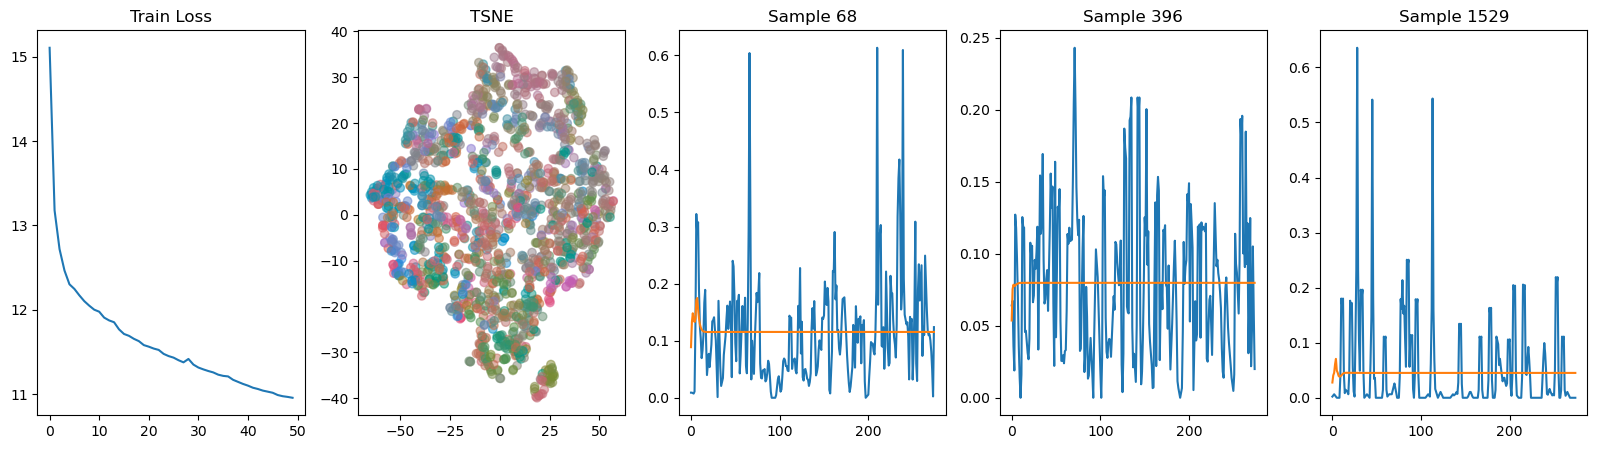

In [128]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)

In [129]:
encoder, decoder, encodings, train_loss = quick_train(
    LSTM_AE,
    train_set = ts_train,
    encoding_dim = 32,
    verbose = True,
    lr=1e-3,
    epochs = 50,
    **{
        "h_dims": [64],
        "h_activ": nn.ReLU(),
        "out_activ": nn.Sigmoid(),
    }
)

encodings = np.stack([np.array(t.detach().cpu()) for t in encodings])
decodings = get_decodings_lstm(encoder, decoder, ts_train, ts_train[0].shape[0])

Epoch: 1, Loss: 18.447621581479908
Epoch: 2, Loss: 15.980632020235062
Epoch: 3, Loss: 17.381758145540953
Epoch: 4, Loss: 17.246342086568475
Epoch: 5, Loss: 17.141235751509665
Epoch: 6, Loss: 17.08346237361431
Epoch: 7, Loss: 16.82495544075966
Epoch: 8, Loss: 16.776252703964712
Epoch: 9, Loss: 16.715899895578623
Epoch: 10, Loss: 16.42359072998166
Epoch: 11, Loss: 16.14587045788765
Epoch: 12, Loss: 16.14960362151265
Epoch: 13, Loss: 16.128580660521983
Epoch: 14, Loss: 16.134025334566832
Epoch: 15, Loss: 16.116535935103894
Epoch: 16, Loss: 16.122614684402944
Epoch: 17, Loss: 16.14738278225064
Epoch: 18, Loss: 16.00547112464905
Epoch: 19, Loss: 15.668056528568268
Epoch: 20, Loss: 15.559174634814262
Epoch: 21, Loss: 15.550334520041943
Epoch: 22, Loss: 15.560293935835361
Epoch: 23, Loss: 15.55859948337078
Epoch: 24, Loss: 15.557109776735306
Epoch: 25, Loss: 15.555349013656377
Epoch: 26, Loss: 15.554700304865838
Epoch: 27, Loss: 15.58064966648817
Epoch: 28, Loss: 15.579291134029626
Epoch: 29,

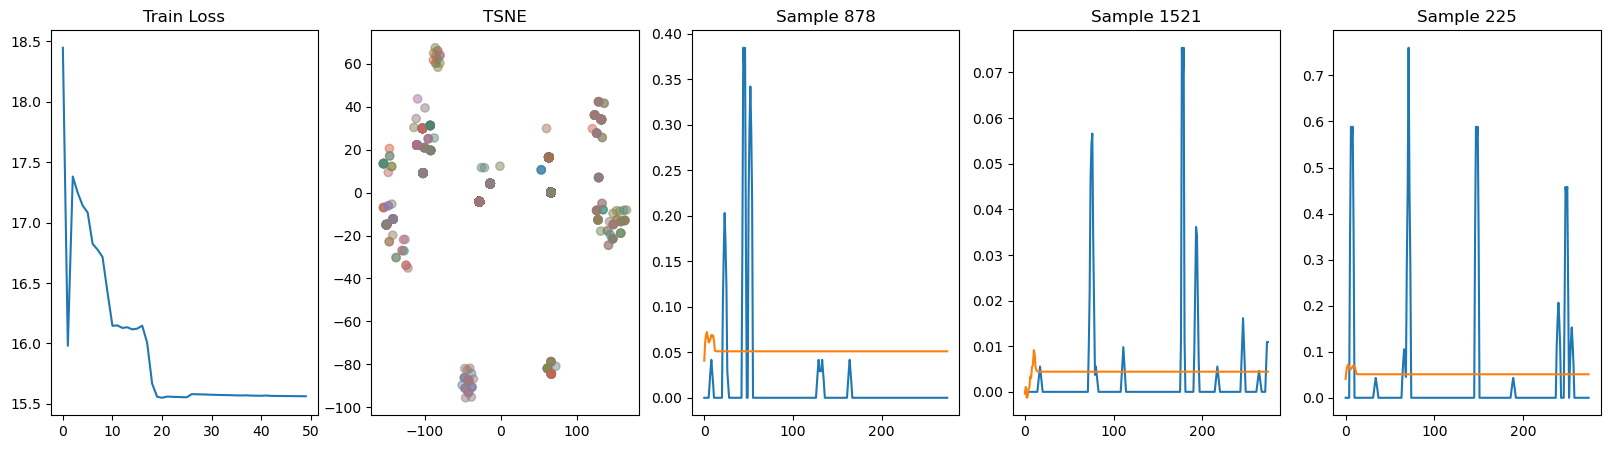

In [130]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)

In [131]:
encoder, decoder, encodings, train_loss = quick_train(
    LSTM_AE,
    train_set = ts_train,
    encoding_dim = 32,
    verbose = True,
    lr=1e-3,
    epochs = 50,
    **{
        "h_dims": [16, 64],
        "h_activ": nn.ReLU(),
        "out_activ": None,
    }
)

encodings = np.stack([np.array(t.detach().cpu()) for t in encodings])
decodings = get_decodings_lstm(encoder, decoder, ts_train, ts_train[0].shape[0])

Epoch: 1, Loss: 16.07864554554224
Epoch: 2, Loss: 16.632516984939574
Epoch: 3, Loss: 17.184579546004535
Epoch: 4, Loss: 17.11777105130255
Epoch: 5, Loss: 17.0445888119936
Epoch: 6, Loss: 17.087294653058052
Epoch: 7, Loss: 17.07393177330494
Epoch: 8, Loss: 17.03499335810542
Epoch: 9, Loss: 17.05050737604499
Epoch: 10, Loss: 17.041066573411225
Epoch: 11, Loss: 16.917677510380745
Epoch: 12, Loss: 16.87507000565529
Epoch: 13, Loss: 16.397973214387893
Epoch: 14, Loss: 15.288795843571425
Epoch: 15, Loss: 16.938496568650006
Epoch: 16, Loss: 16.915781366676093
Epoch: 17, Loss: 16.905733698904513
Epoch: 18, Loss: 16.876896005123854
Epoch: 19, Loss: 16.8684327173233
Epoch: 20, Loss: 16.86347684890032
Epoch: 21, Loss: 16.859268804639576
Epoch: 22, Loss: 16.80929402843118
Epoch: 23, Loss: 16.80275290668011
Epoch: 24, Loss: 16.786645535230637
Epoch: 25, Loss: 16.797308911830186
Epoch: 26, Loss: 16.795610492676495
Epoch: 27, Loss: 16.87219514966011
Epoch: 28, Loss: 16.906143260896204
Epoch: 29, Loss

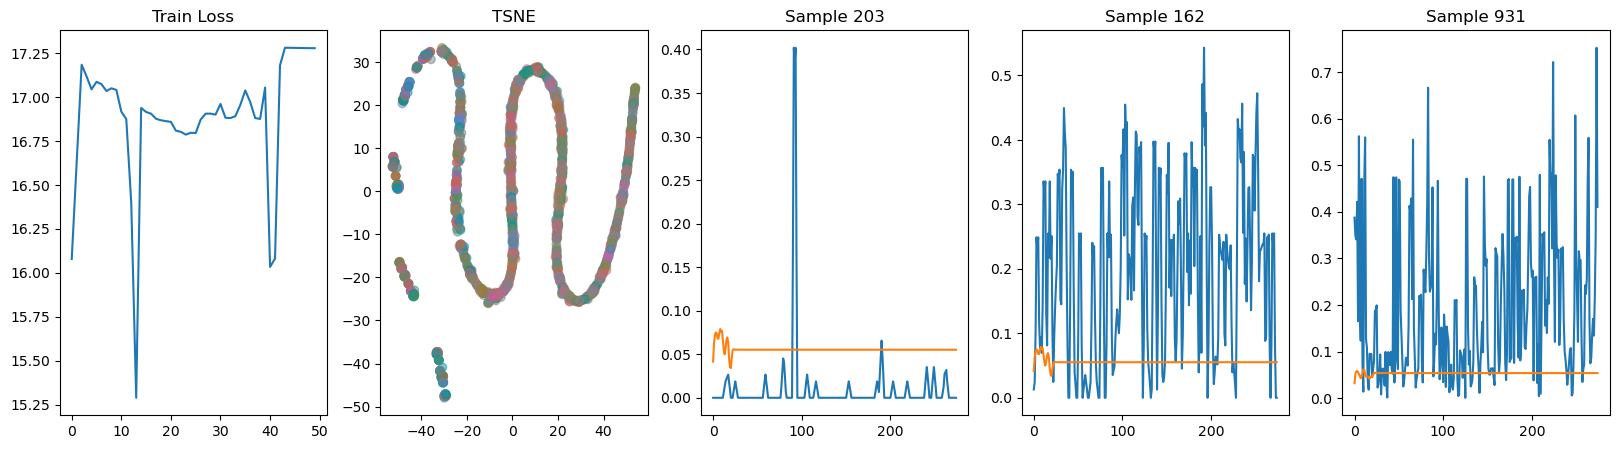

In [132]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)

In [134]:
encoder, decoder, encodings, train_loss = quick_train(
    LSTM_AE,
    train_set = ts_train,
    encoding_dim = 64,
    verbose = True,
    lr=1e-3,
    epochs = 50,
    **{
        "h_dims": [16, 32, 64, 64,],
        "h_activ": nn.ReLU(),
        "out_activ": None,
    }
)

encodings = np.stack([np.array(t.detach().cpu()) for t in encodings])
decodings = get_decodings_lstm(encoder, decoder, ts_train, ts_train[0].shape[0])

Epoch: 1, Loss: 20.746150123476983
Epoch: 2, Loss: 17.695048185139896
Epoch: 3, Loss: 17.58319981150329
Epoch: 4, Loss: 17.519571657925844
Epoch: 5, Loss: 17.465189297944306


In [ ]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)

### Conv1d AutoEncoder

In [61]:
from ae import *

In [92]:
ts = [t.T for t in ts]
ts_train = [torch.tensor(ts[i], dtype = torch.float32) for i in train_idx]
ts_val = [torch.tensor(ts[i], dtype = torch.float32) for i in val_idx]
ts_train_np = [t.numpy() for t in ts_train]
ts_train = DataLoader(ts_train, batch_size = args.batch_size, shuffle = False)
ts_val = DataLoader(ts_val, batch_size = args.batch_size, shuffle = False)

In [93]:
model = AutoencoderConv(
    input_dim = ts[0].shape[0],
    encoding_dim = 32,
    seq_len = ts[0].shape[1],
    h_dims = [64, 32],
    h_activ = nn.ReLU(),
    out_activ = nn.Sigmoid()
)

train_loss, val_loss = train_model(
    model,
    ts_train,
    ts_val,
    args,
    verbose = False
)

encodings = get_encodings(model, ts_train, args)
decodings = get_decodings(model, ts_train, args)

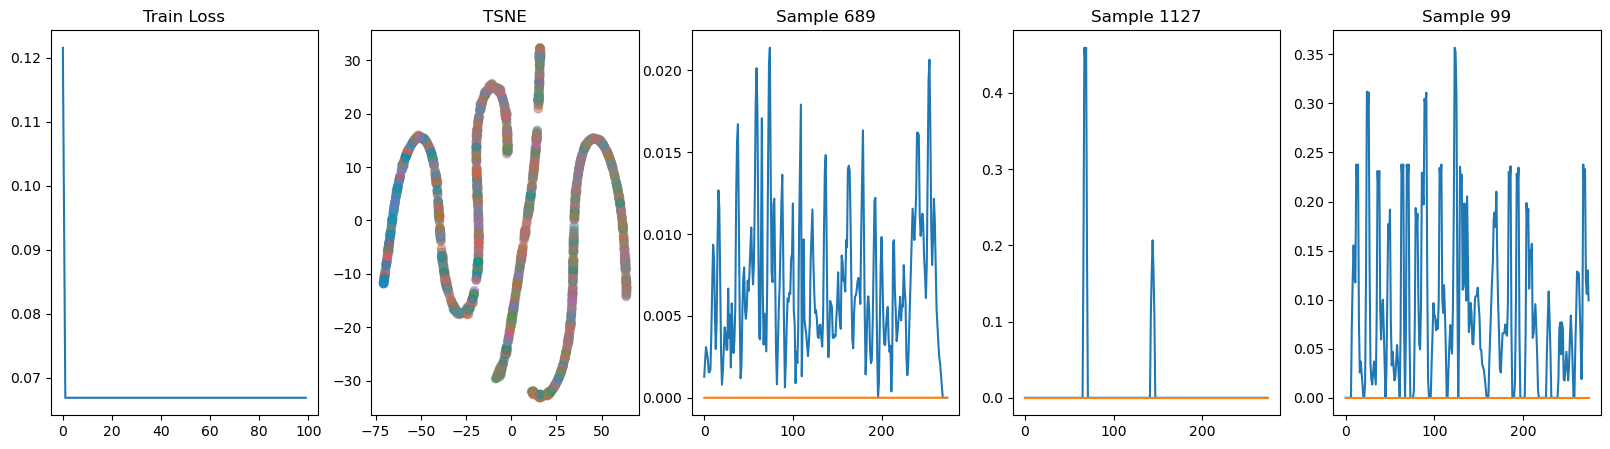

In [96]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)

In [99]:
model = AutoencoderConv(
    input_dim = ts[0].shape[0],
    encoding_dim = 32,
    seq_len = ts[0].shape[1],
    h_dims = [16, 16],
    h_activ = nn.ReLU(),
    out_activ = nn.Sigmoid()
)

train_loss, val_loss = train_model(
    model,
    ts_train,
    ts_val,
    args,
    verbose = False
)

encodings = get_encodings(model, ts_train, args)
decodings = get_decodings(model, ts_train, args)

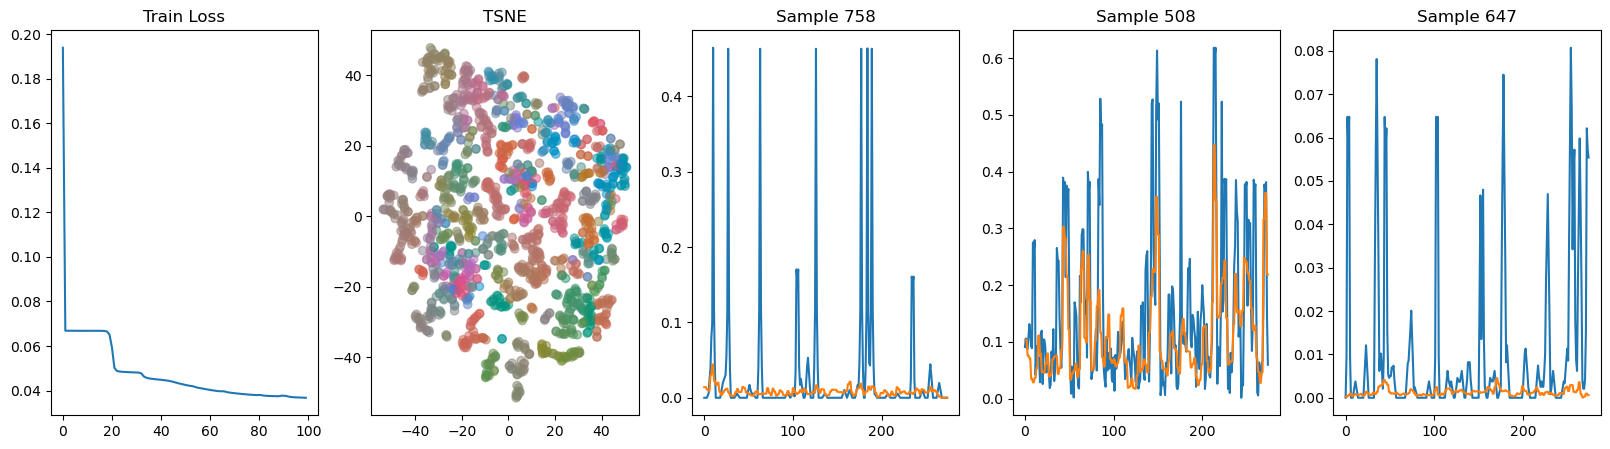

In [100]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)

In [97]:
model = AutoencoderConv(
    input_dim = ts[0].shape[0],
    encoding_dim = 32,
    seq_len = ts[0].shape[1],
    h_dims = [64, 32],
    h_activ = nn.ReLU(),
    out_activ = nn.Identity()
)

train_loss, val_loss = train_model(
    model,
    ts_train,
    ts_val,
    args,
    verbose = False
)

encodings = get_encodings(model, ts_train, args)
decodings = get_decodings(model, ts_train, args)

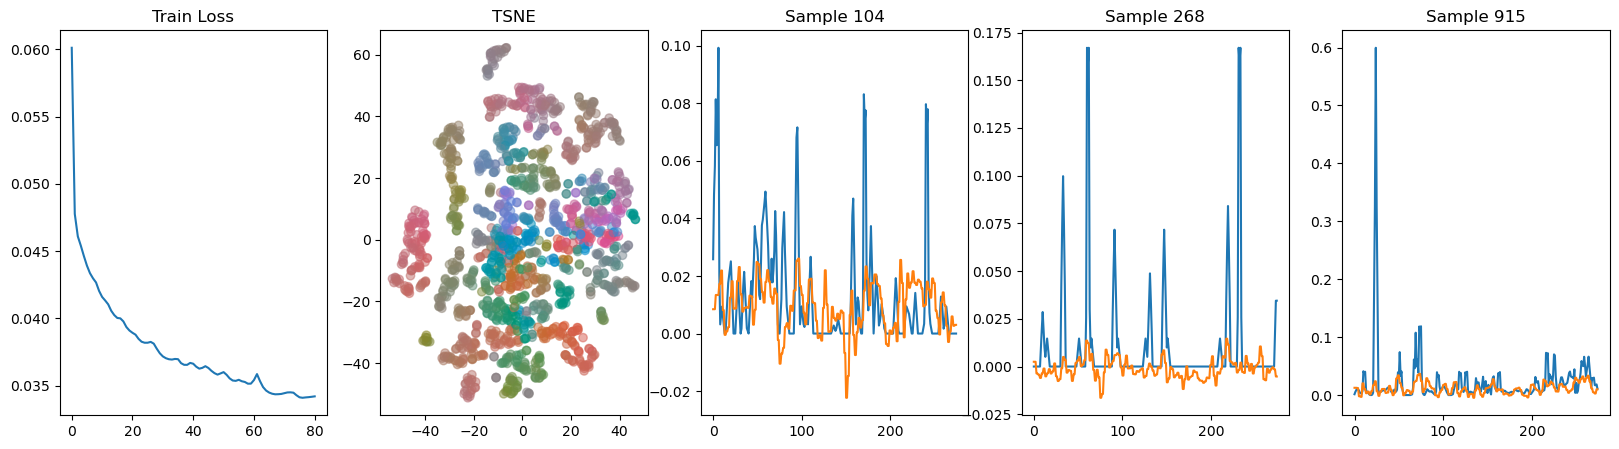

In [98]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)

In [101]:
model = AutoencoderConv(
    input_dim = ts[0].shape[0],
    encoding_dim = 32,
    seq_len = ts[0].shape[1],
    h_dims = [16, 16],
    h_activ = nn.ReLU(),
    out_activ = nn.Identity()
)

train_loss, val_loss = train_model(
    model,
    ts_train,
    ts_val,
    args,
    verbose = False
)

encodings = get_encodings(model, ts_train, args)
decodings = get_decodings(model, ts_train, args)

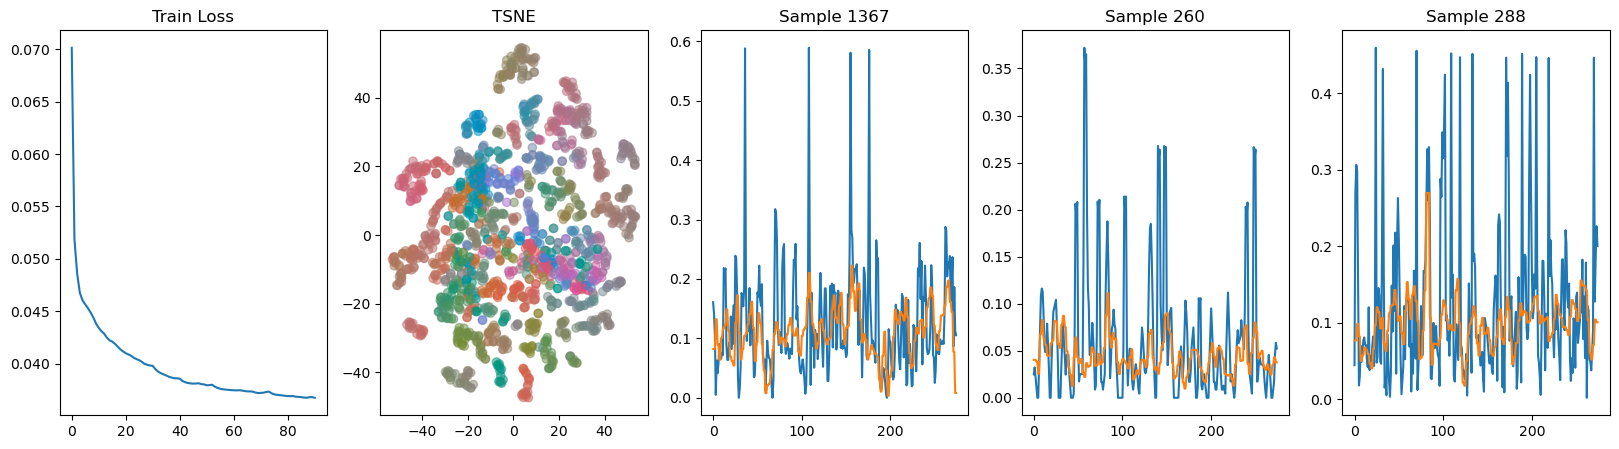

In [102]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)

In [103]:
model = AutoencoderConv(
    input_dim = ts[0].shape[0],
    encoding_dim = 10,
    seq_len = ts[0].shape[1],
    h_dims = [16, 64],
    h_activ = nn.ReLU(),
    out_activ = nn.Identity()
)

train_loss, val_loss = train_model(
    model,
    ts_train,
    ts_val,
    args,
    verbose = False
)

encodings = get_encodings(model, ts_train, args)
decodings = get_decodings(model, ts_train, args)

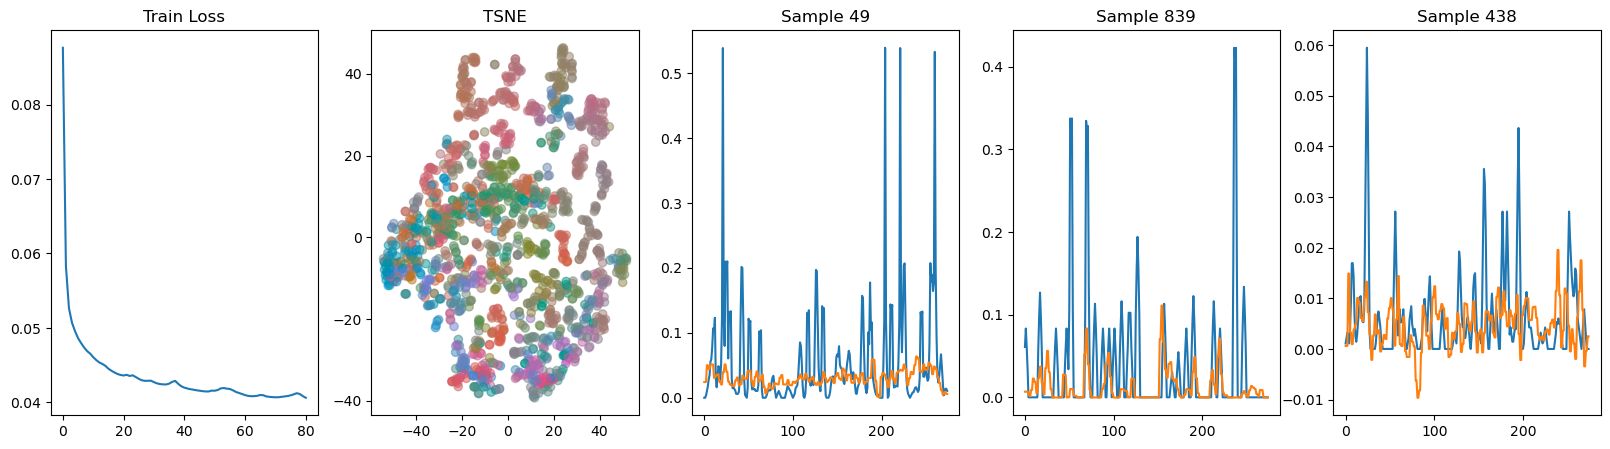

In [104]:
plot_model_analysis(
    train_loss,
    encodings,
    colors,
    ts_train_np,
    decodings,
)